# 5 The Many Variables & The Spurious Waffles

In [18]:
import math
import os

import arviz as az
import daft
import matplotlib.pyplot as plt
import pandas as pd
from causalgraphicalmodels import CausalGraphicalModel

import jax.numpy as jnp
from jax import random

import numpyro
import numpyro.distributions as dist
import numpyro.optim as optim
from numpyro.diagnostics import print_summary
from numpyro.infer import Predictive, SVI, Trace_ELBO
from numpyro.infer.autoguide import AutoLaplaceApproximation

if "SVG" in os.environ:
    %config InlineBackend.figure_formats = ["svg"]
az.style.use("arviz-darkgrid")
numpyro.set_platform("cpu")

## 5.1 Spurious associations

In [19]:
# 5.1
# load data and copy
WaffleDivorce = pd.read_csv("../data/WaffleDivorce.csv", sep=";")
d = WaffleDivorce

# standardize
d['A'] = d.MedianAgeMarriage.pipe(lambda x: (x-x.mean())/x.std())
d['D'] = d.Divorce.pipe(lambda x: (x-x.mean())/x.std())

In [20]:
# 5.2
# how big a standard deviation is age at marriage?
d.MedianAgeMarriage.std()

1.2436303013880823

Given a model:

$$D_i ∼ \text{Normal}(μ_i, σ)$$

$$μ_i = α + β_{A}A_{i}$$

$$α ∼ \text{Normal}(0, 0.2) $$

$$β_A ∼ \text{Normal}(0, 0.5) $$

$$σ ∼ \text{Exponential}(1)$$


, when $\beta_{A}$ = 1, and the above std., a change of 1.2 years in median age at marriage ($A_i$) is associated with a full standard deviation change in the outcome variable.

In [21]:
# 5.3
# simulation of priors in the predictive prior distribution

def model(A, D=None):
    a = numpyro.sample("a", dist.Normal(0, 0.2))
    bA = numpyro.sample("bA", dist.Normal(0, 0.5))
    sigma = numpyro.sample("sigma", dist.Exponential(1))
    mu = numpyro.deterministic("mu", a + bA * A)
    numpyro.sample("D", dist.Normal(mu, sigma), obs=D)


m5_1 = AutoLaplaceApproximation(model)
svi = SVI(model, m5_1, optim.Adam(1), Trace_ELBO(), A=d.A.values, D=d.D.values)
svi_result = svi.run(random.PRNGKey(0), 1000)
p5_1 = svi_result.params

100%|█| 1000/1000 [00:00<00:00, 6415.37it/s, init loss: 2138.6682, avg. loss [95


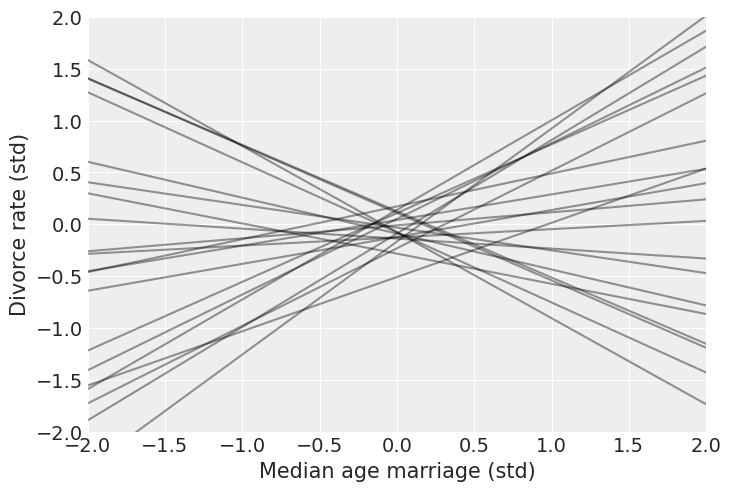

In [22]:
# 5.4
predictive = Predictive(m5_1.model,
                        num_samples=1000,
                        return_sites=['mu'])
prior_pred = predictive(random.PRNGKey(10),
                        A=jnp.array([-2,2]))
mu = prior_pred['mu']

# plot predictive distribution of prior mu
plt.subplot(xlim=(-2, 2), ylim=(-2, 2))
for i in range(20):
    plt.plot([-2, 2], mu[i], "k", alpha=0.4)
    plt.xlabel('Median age marriage (std)')
    plt.ylabel('Divorce rate (std)')

Note: These are possible predictors for the relationship between median age at marriage and divorce rate from simulations with the priors. Data shown in **Figure 5.2** in the book indicates we expect negative linear relationships, however some priors simulated here would imply a positive linear relationship.

We will simulate some other flatter priors to see how much worse the prior regression lines can become.

100%|█| 1000/1000 [00:00<00:00, 5758.88it/s, init loss: 190.6541, avg. loss [951


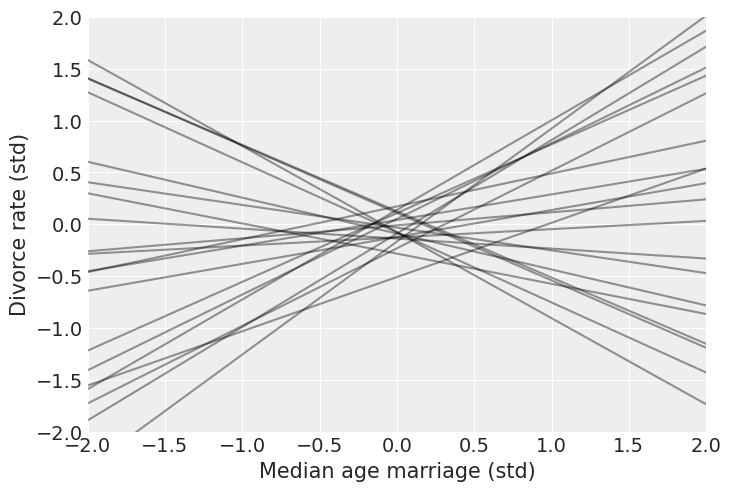

In [23]:
# 5.3
# simulation of priors in the predictive prior distribution

def model(A, D=None):
    a = numpyro.sample('a', dist.Normal(0, 0.2))
    bA = numpyro.sample('b', dist.Normal(4, 3))
    sigma = numpyro.sample('sigma', dist.Uniform(0, 5))
    mu = numpyro.deterministic('mu', a + bA * A)
    numpyro.sample('D', dist.Normal(mu, sigma), obs=D)

m5_1_alt = AutoLaplaceApproximation(model)
svi = SVI(model,
          m5_1_alt,
          optim.Adam(1),
          Trace_ELBO(),
          A=d.A.values,
          D=d.D.values)
svi_result = svi.run(random.PRNGKey(0), 1000)
p5_1_alt = svi_result.params

# 5.4
predictive_alt = Predictive(m5_1_alt.model,
                        num_samples=1000,
                        return_sites=['mu'])
prior_pred_alt = predictive(random.PRNGKey(10),
                        A=jnp.array([-2,2]))
mu_alt = prior_pred['mu']

# plot predictive distribution of prior mu
plt.subplot(xlim=(-2, 2), ylim=(-2, 2))
for i in range(20):
    plt.plot([-2, 2], mu[i], "k", alpha=0.4)
    plt.xlabel('Median age marriage (std)')
    plt.ylabel('Divorce rate (std)')

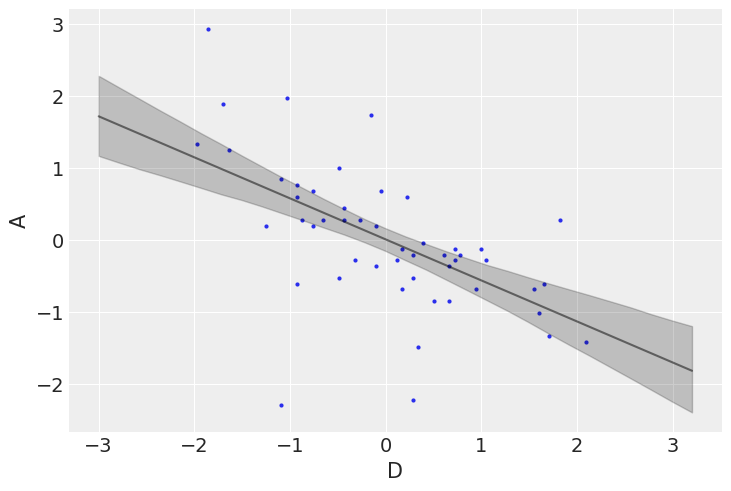

In [26]:
# 5.5
# sample the posterior predictive distribution
A_seq = jnp.linspace(start=-3, stop=3.2, num=30)
post = m5_1.sample_posterior(random.PRNGKey(1), p5_1, (1000,))
post_pred = Predictive(m5_1.model,
                       post)(random.PRNGKey(2), A=A_seq)

# summarise the mean and 89% PI of predicted mu
mu = post_pred['mu']
mu_mean = jnp.mean(mu, 0)
mu_PI = jnp.percentile(mu, q=jnp.array([5.5,94.5]), axis=0)

# plot
az.plot_pair(d[['D', 'A']].to_dict(orient='list'))
plt.plot(A_seq, mu_mean, "k", alpha=0.5)
plt.fill_between(A_seq, mu_PI[0], mu_PI[1], color="k", alpha=0.2)
plt.show()

100%|█| 1000/1000 [00:00<00:00, 6491.30it/s, init loss: 962.7464, avg. loss [951


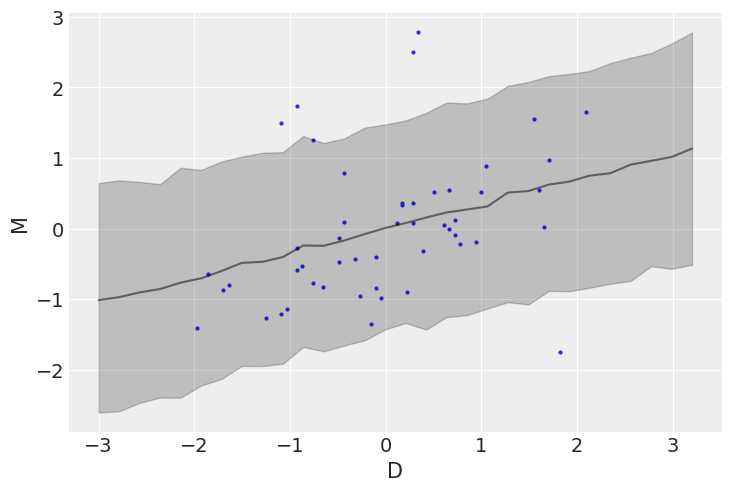

In [27]:
# 5.6
# construct a predictor for divorce rate (D) from marriage rate (M)
d["M"] = d.Marriage.pipe(lambda x: (x - x.mean()) / x.std())


def model(M, D=None):
    a = numpyro.sample("a", dist.Normal(0, 0.2))
    bM = numpyro.sample("bM", dist.Normal(0, 0.5))
    sigma = numpyro.sample("sigma", dist.Exponential(1))
    mu = a + bM * M
    numpyro.sample("D", dist.Normal(mu, sigma), obs=D)


m5_2 = AutoLaplaceApproximation(model)
svi = SVI(model, m5_2, optim.Adam(1), Trace_ELBO(), M=d.M.values, D=d.D.values)
svi_result = svi.run(random.PRNGKey(0), 1000)
p5_2 = svi_result.params


# sample the posterior predictive distribution
M_seq = jnp.linspace(start=-3, stop=3.2, num=30)
post = m5_2.sample_posterior(random.PRNGKey(1), p5_2, (1000,))
post_pred = Predictive(m5_2.model,
                       post)(random.PRNGKey(2), M=M_seq)
post_pred


# summarise the mean and 89% PI of predicted mu
mu = post_pred['D']
mu_mean = jnp.mean(mu, 0)
mu_PI = jnp.percentile(mu, q=jnp.array([5.5,94.5]), axis=0)

# plot
az.plot_pair(d[['D', 'M']].to_dict(orient='list'))
plt.plot(A_seq, mu_mean, "k", alpha=0.5)
plt.fill_between(A_seq, mu_PI[0], mu_PI[1], color="k", alpha=0.2)
plt.show()

**Overthinking: Drawing a DAG**

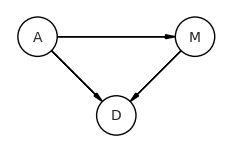

In [28]:
# 5.7
dag5_1 = CausalGraphicalModel(
    nodes = ['A','D','M'],
    edges = [('A','D'), ('A','M'), ('M','D')]
)
# base object for building a graphical model representation
pgm = daft.PGM()

coordinates = {"A": (0, 0), "D": (1, 1), "M": (2, 0)}
for node in dag5_1.dag.nodes:
    pgm.add_node(node, node, *coordinates[node])
for edge in dag5_1.dag.edges:
    pgm.add_edge(*edge)
with plt.rc_context({"figure.constrained_layout.use": False}):
    pgm.render()
plt.gca().invert_yaxis()

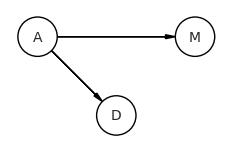

In [29]:
dag2 = CausalGraphicalModel(nodes=["A", "D", "M"], edges=[("A", "D"), ("A", "M")])
pgm = daft.PGM()

coordinates = {"A": (0, 0), "D": (1, 1), "M": (2, 0)}
for node in dag2.dag.nodes:
    pgm.add_node(node, node, *coordinates[node])
for edge in dag2.dag.edges:
    pgm.add_edge(*edge)
with plt.rc_context({"figure.constrained_layout.use": False}):
    pgm.render()
plt.gca().invert_yaxis()

### 5.1.2 Testable implications

“Conditional independencies come in two forms. First, they are statements of which variables should be associated with one another (or not) in the data. Second, they are statements of which variables become dis-associated when we condition on some other set of variables.”

- For the first DAG above, every pair of variables is correlated due to the causal arrows. Therefore, the first **testable implication** is that all three pairs are not independent of each other.
- For the second DAG above, a testable implication is that D is independent of M, conditional on A.
- This thing does not happen for the first DAG above, because conditioning on A does not make DP independent of M.

In [30]:
# 5.8
# return the independencies for the second DAG
DMA_dag2 = CausalGraphicalModel(nodes=["A", "D", "M"], edges=[("A", "D"), ("A", "M")])
all_independencies = DMA_dag2.get_all_independence_relationships()
for s in all_independencies:
    if all(
        t[0] != s[0] or t[1] != s[1] or not t[2].issubset(s[2])
        for t in all_independencies
        if t != s
    ):
        print(s)

('D', 'M', {'A'})


Above reads as "D \_||#_ M | A"

In [31]:
# 5.9
# return the independencies for the first DAG
DMA_dag2 = CausalGraphicalModel(
    nodes=["A", "D", "M"], edges=[("A", "D"), ("A", "M"), ("M", "D")]
)
all_independencies = DMA_dag2.get_all_independence_relationships()
for s in all_independencies:
    if all(
        t[0] != s[0] or t[1] != s[1] or not t[2].issubset(s[2])
        for t in all_independencies
        if t != s
    ):
        print(s)

And here, we observe no conditional independencies in the output.

### 5.1.3 Multiple regression notation

To test the implication of the DAGs above, we need a statistical model that conditions on A, so we can see whether it renders D independent of M.

This is where multiple regression comes in, addressing the type of descriptive question as posed here: _"Is there any additional value in knowing a variable, once I already know all of the other predictor variables?"_

Parameter estimates corresponding to each predictor can inform answers to questions of "Does knowing marriage the rate already render knowing age at marriage useful in predicting the divorce rate?" and vice versa.

“(1) Nominate the predictor variables you want in the linear model of the mean.

(2) For each predictor, make a parameter that will measure its association with the outcome.

(3) Multiply the parameter by the variable and add that term to the linear model.”

### 5.1.4 Approximating the posterior

In [39]:
# 5.10
def model(M, A, D=None):
    a = numpyro.sample('a', dist.Normal(0,0.2))
    bM = numpyro.sample('bM', dist.Normal(0,0.5))
    bA = numpyro.sample('bA', dist.Normal(0,0.5))
    sigma = numpyro.sample('sigma', dist.Exponential(1))
    mu = numpyro.deterministic('mu', a + bM * M + bA * A)
    numpyro.sample('D', dist.Normal(mu, sigma), obs=D)

m5_3 = AutoLaplaceApproximation(model)
svi = SVI(
    model,
    m5_3,
    optim.Adam(1),
    Trace_ELBO(),
    M = d.M.values,
    A = d.A.values,
    D=d.D.values
)
svi_result = svi.run(random.PRNGKey(0), 1000)
p5_3 = svi_result.params

# sample posterior distribution
post = m5_3.sample_posterior(random.PRNGKey(1), p5_3, (1000,))

# print summary of parameters
print_summary(post, 0.89, False)

100%|█| 1000/1000 [00:00<00:00, 5993.01it/s, init loss: 3201.7393, avg. loss [95



                mean       std    median      5.5%     94.5%     n_eff     r_hat
         a     -0.00      0.10     -0.01     -0.16      0.14   1049.96      1.00
        bA     -0.61      0.16     -0.61     -0.86     -0.35    984.99      1.00
        bM     -0.06      0.16     -0.06     -0.31      0.19    822.38      1.00
     mu[0]      0.37      0.14      0.36      0.15      0.58   1052.80      1.00
     mu[1]      0.32      0.20      0.32      0.02      0.66    917.91      1.00
     mu[2]      0.12      0.10      0.12     -0.04      0.27   1094.94      1.00
     mu[3]      0.76      0.21      0.75      0.43      1.09   1089.30      1.00
     mu[4]     -0.35      0.12     -0.35     -0.53     -0.16    869.88      1.00
     mu[5]      0.12      0.15      0.12     -0.10      0.36    968.97      1.00
     mu[6]     -0.71      0.17     -0.71     -0.98     -0.43    895.70      1.00
     mu[7]     -0.31      0.20     -0.32     -0.65      0.00    860.00      1.00
     mu[8]     -1.74      0

Posterior mean of marriage rate (bM) is close to zero, but spread around to both positive and negative values in the 89% PI.

bA on the other hand is spread within the negative domain by its 89% PI.

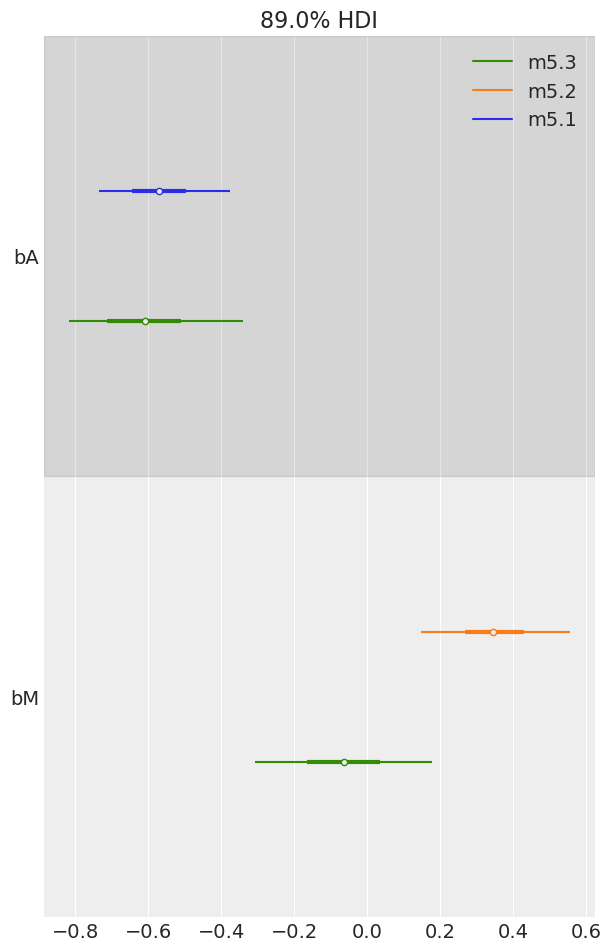

In [40]:
coeftab = {
    "m5.1": m5_1.sample_posterior(
        random.PRNGKey(1),
        p5_1,
        (
            1,
            1000,
        ),
    ),
    "m5.2": m5_2.sample_posterior(
        random.PRNGKey(2),
        p5_2,
        (
            1,
            1000,
        ),
    ),
    "m5.3": m5_3.sample_posterior(
        random.PRNGKey(3),
        p5_3,
        (
            1,
            1000,
        ),
    ),
}
az.plot_forest(
    list(coeftab.values()),
    model_names=list(coeftab.keys()),
    var_names=["bA", "bM"],
    hdi_prob=0.89,
)
plt.show()

We observe that bM has become less informative in model `m5.3`, meaning that bM is only associated with divorce when age at marriage is missing from the model (`m5.2`).

We can interpret this as: Knowing the median age of marriage for a given state, there is little or no additional predictive power in also knowing the rate of marriage in that stage.

#### Overthinking: Simulating the divorce example

In [41]:
# 5.12
N = 50  # number of simulated States
age = dist.Normal().sample(random.PRNGKey(0), sample_shape=(N,))  # sim A
mar = dist.Normal(age).sample(random.PRNGKey(1))  # sim A -> M
div = dist.Normal(age).sample(random.PRNGKey(2))  # sim A -> D

In [42]:
# 5.10
def model(M, A, D=None):
    a = numpyro.sample('a', dist.Normal(0,0.2))
    bM = numpyro.sample('bM', dist.Normal(0,0.5))
    bA = numpyro.sample('bA', dist.Normal(0,0.5))
    sigma = numpyro.sample('sigma', dist.Exponential(1))
    mu = numpyro.deterministic('mu', a + bM * M + bA * A)
    numpyro.sample('D', dist.Normal(mu, sigma), obs=D)

m5_3_sim = AutoLaplaceApproximation(model)
svi = SVI(
    model,
    m5_3_sim,
    optim.Adam(1),
    Trace_ELBO(),
    M = mar,
    A = age,
    D = div
)
svi_result = svi.run(random.PRNGKey(0), 1000)
p5_3_sim = svi_result.params

# sample posterior distribution
post = m5_3_sim.sample_posterior(random.PRNGKey(1), p5_3_sim, (1000,))

# print summary of parameters
print_summary(post, 0.89, False)

100%|█| 1000/1000 [00:00<00:00, 5237.91it/s, init loss: 2425.0813, avg. loss [95



                mean       std    median      5.5%     94.5%     n_eff     r_hat
         a      0.12      0.11      0.11     -0.06      0.28   1049.96      1.00
        bA      0.70      0.16      0.70      0.39      0.92    935.67      1.00
        bM      0.03      0.13      0.03     -0.17      0.25    867.63      1.00
     mu[0]     -0.05      0.17     -0.05     -0.32      0.22    968.09      1.00
     mu[1]     -0.74      0.22     -0.74     -1.09     -0.39   1023.78      1.00
     mu[2]     -0.55      0.17     -0.54     -0.83     -0.30   1089.10      1.00
     mu[3]      0.22      0.12      0.22      0.01      0.39    973.45      1.00
     mu[4]      0.14      0.13      0.14     -0.08      0.35    927.58      1.00
     mu[5]     -0.42      0.15     -0.42     -0.66     -0.19   1108.84      1.00
     mu[6]     -0.43      0.19     -0.43     -0.71     -0.12    970.83      1.00
     mu[7]      0.27      0.27      0.27     -0.17      0.72    818.68      1.00
     mu[8]     -0.03      0

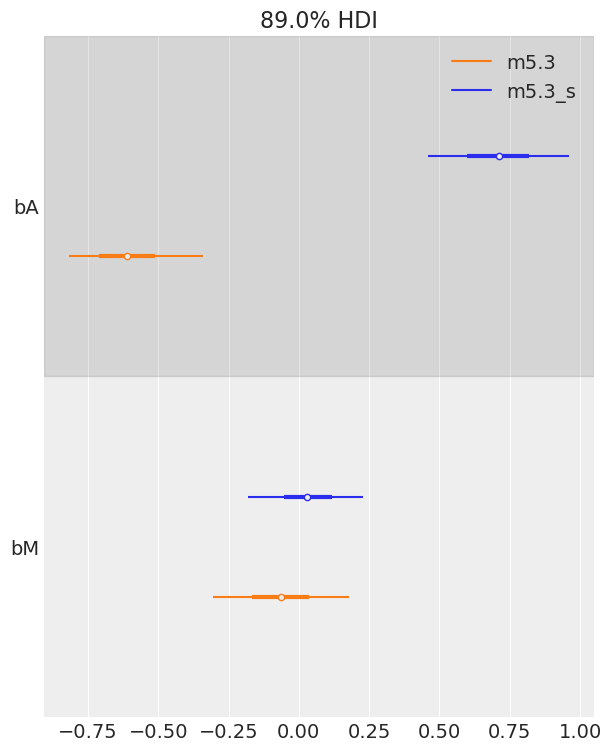

In [43]:
coeftab = {
    "m5.3_s": m5_3_sim.sample_posterior(
        random.PRNGKey(2),
        p5_3_sim,
        (
            1,
            1000,
        ),
    ),
    "m5.3": m5_3.sample_posterior(
        random.PRNGKey(3),
        p5_3,
        (
            1,
            1000,
        ),
    ),
}
az.plot_forest(
    list(coeftab.values()),
    model_names=list(coeftab.keys()),
    var_names=["bA", "bM"],
    hdi_prob=0.89,
)
plt.show()

### 5.1.5 Plotting multivariate posteriors

#### 5.1.5.1 Predictor residual plots

As before, M is marriage rate and A is median age at marriage. Note that since we standardized both variables, we already expect the mean α to be around zero, as before. So I’m reusing the same priors as earlier. This code will approximate the posterior:

In [44]:
# 5.13
def model(A, M=None):
    a = numpyro.sample("a", dist.Normal(0, 0.2))
    bAM = numpyro.sample("bA", dist.Normal(0, 0.5))
    sigma = numpyro.sample("sigma", dist.Exponential(1))
    mu = numpyro.deterministic("mu", a + bAM * A)
    numpyro.sample("M", dist.Normal(mu, sigma), obs=M)


m5_4 = AutoLaplaceApproximation(model)
svi = SVI(model, m5_4, optim.Adam(0.1), Trace_ELBO(), A=d.A.values, M=d.M.values)
svi_result = svi.run(random.PRNGKey(0), 1000)
p5_4 = svi_result.params

100%|█| 1000/1000 [00:00<00:00, 5611.64it/s, init loss: 2288.6685, avg. loss [95


And then we compute the residuals by subtracting the observed marriage rate in each State from the predicted rate, based upon the model above:

In [45]:
# 5.14
post = m5_4.sample_posterior(random.PRNGKey(1), p5_4, (1000,))
post_pred = Predictive(m5_4.model, post)(random.PRNGKey(2), A=d.A.values)
mu = post_pred["mu"]
mu_mean = jnp.mean(mu, 0)
mu_resid = d.M.values - mu_mean

In [46]:
mu_resid

Array([-0.404817  ,  1.0664229 , -0.09889868,  0.6684858 ,  0.14431378,
        0.6877534 ,  0.06504852,  1.0856906 ,  1.3973002 , -0.632293  ,
        0.4309644 ,  1.7273889 , -0.10458982, -0.05981463, -0.2864678 ,
       -0.00660545, -0.07229406, -0.15779889,  0.03600985, -1.5538536 ,
        0.21325934,  0.22601295, -0.7639445 , -1.1358259 , -0.3622017 ,
       -0.65834904, -0.6287617 , -0.5068812 , -0.4876135 , -0.48463076,
       -0.07256838,  0.4333986 , -0.12848598,  1.3066527 , -0.71454096,
        0.03981543, -0.35568768, -0.63582426, -0.15238237, -0.34265965,
       -0.2633945 , -0.67137706, -0.11844072,  0.95187926, -0.5106868 ,
        0.28926757,  0.24665228, -0.04596376, -0.63555   ,  1.7447712 ],      dtype=float32)

“In simpler terms, States with positive residuals have high marriage rates for their median age of marriage, while States with negative residuals have low rates for their median age of marriage”

#### 5.1.5.2 Posterior prediction plots

Useful to:

- (1) Check if the model correctly approximated the posterior distribution
- (2) Check how the model fails

In [47]:
# 5.15

# Predictive() without new data makes the function use the original (observed) data
post = m5_3.sample_posterior(random.PRNGKey(1),
                             p5_3,
                             (int(1e4),))
post_pred = Predictive(m5_3.model, post)(random.PRNGKey(2), M=d.M.values, A=d.A.values)
mu = post_pred["mu"]

# summarise samples
mu_mean = jnp.mean(mu, 0)
mu_PI = jnp.percentile(mu, q=jnp.array([5.5,94.5]), axis=0)

# simulate observation (use original data)
D_sim = post_pred['D']
D_PI = jnp.percentile(D_sim, q=jnp.array([5.5,94.5]), axis=0)

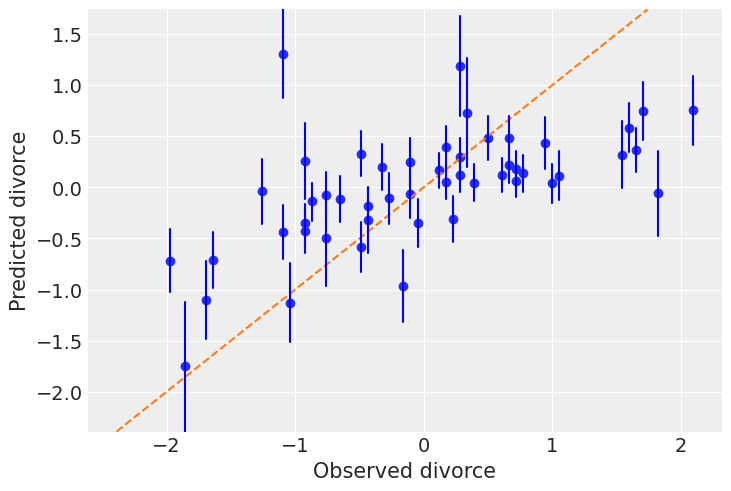

In [59]:
# 5.16
# plot predictions against observed

ax = plt.subplot(
    ylim=(float(mu_PI.min()), float(mu_PI.max())),
    xlabel="Observed divorce",
    ylabel="Predicted divorce",
)
plt.plot(d.D, mu_mean, "o")
x = jnp.linspace(mu_PI.min(), mu_PI.max(), 101)
plt.plot(x, x, "--")
for i in range(d.shape[0]):
    plt.plot([d.D[i]] * 2, mu_PI[:, i], "b")
fig = plt.gcf()

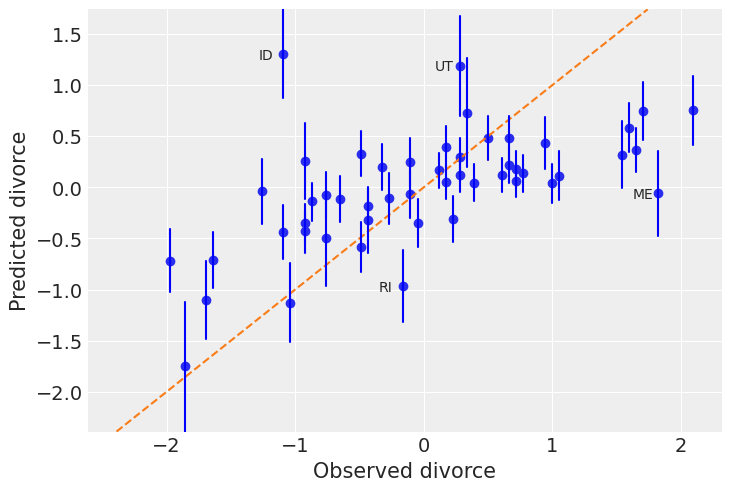

In [60]:
# 5.17
# plot and highlight tricky states for predictions

for i in range(d.shape[0]):
    if d.Loc[i] in ["ID", "UT", "RI", "ME"]:
        ax.annotate(
            d.Loc[i], (d.D[i], mu_mean[i]), xytext=(-25, -5), textcoords="offset pixels"
        )
fig

#### 5.1.5.3 Counterfactual plots